<div class="alert alert-block alert-info">
<center> <h1> MACHINE LEARNING MDSAA-BA </h1> </center> <br>
<center> TECHSCAPE PROJECT 2021/2022 </center>

### DÚVIDAS:

### TO DO:

**Table of Contents** <br>
* [1. Import](#import)
    * [1.1. Import Libraries](#importlibraries)
    * [1.2. Import the Dataset](#importdataset)
* [2. Initial Analysis](#initialanalysis)
* [3. Definition of the initial Metric and Non-metric Features](#defeatures)
* [4. Impute Missing Values on Non-Metric Features](#imputeMV)
* [5. Further Analysis](#FurtherAnalysis)
* [6. Variables' Distribution](#VarsDistribution)
    * [6.1. Categorical Variables - Histograms](#CatVarDist)
    * [6.2. Numeric Variables - Histograms](#NumVarDist)
    * [6.3. Numeric Variables - Boxplots](#NumVarBox)
* [7. Coherence Checking](#Check)
* [8. Transform Variables](#TransformVar)
* [9. Coherence Checking - Age](#CheckAge)
* [10. Outlier Removal](#outlier)
    * [10.1. Outlier Removal - Defining Features](#outdefeatures)
    * [10.2. Variables' Histograms](#hist)
    * [10.3. Outlier Removal - Filtering](#outfiltering)
         * [10.3.1. Filters 1 - Manual](#manual)
         * [10.3.2. Filters 2 - IQR](#iqr)
         * [10.3.3. Filters 3 - Manual & IQR](#manualiqr)

<a class="anchor" id="importlibraries">

## 1.1. Import Libraries

</a>

In [1]:
import pandas as pd
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import calendar

import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut

from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest

from sklearn.neural_network import MLPClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="importdataset">

## 1.2. Import the Dataset

</a>

In [2]:
techscape = pd.read_csv('train.csv')

print(techscape.shape)
techscape.head(3)

(9999, 17)


,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,21-Mar-20,0,0.0,0,0.0,3,64.0,0.0000,0.0667,0.0,MacOSX,2,Portugal,1,Returner,0
1,103117814,20-May-20,0,0.0,0,0.0,23,684.5,0.0217,0.0449,0.0,Windows,2,France,6,Returner,0
2,103201891,4-Dec-20,0,0.0,0,0.0,8,95.0,0.0250,0.0583,0.0,Windows,4,Italy,1,Returner,0


# Check for missing data

In [3]:
techscape.info()
# There are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Access_ID                   9999 non-null   int64  
 1   Date                        9999 non-null   object 
 2   AccountMng_Pages            9999 non-null   int64  
 3   AccountMng_Duration         9999 non-null   float64
 4   FAQ_Pages                   9999 non-null   int64  
 5   FAQ_Duration                9999 non-null   float64
 6   Product_Pages               9999 non-null   int64  
 7   Product_Duration            9999 non-null   float64
 8   GoogleAnalytics_BounceRate  9999 non-null   float64
 9   GoogleAnalytics_ExitRate    9999 non-null   float64
 10  GoogleAnalytics_PageValue   9999 non-null   float64
 11  OS                          9999 non-null   object 
 12  Browser                     9999 non-null   int64  
 13  Country                     9999 

# Change the types of the variables

In [4]:
def change_data_types(df):
    # ID does not make sense to be a int
    df.Access_ID = df.Access_ID.astype('string') 

    # Tranform Date into a datetime format
    df.Date = pd.to_datetime(df.Date)
    
    # Transform these variables into Strings
    df.OS = df.OS.astype('string') 
    df.Country = df.Country.astype('string') 
    df.Type_of_Visitor = df.Type_of_Visitor.astype('string') 
    df.Type_of_Traffic = df.Type_of_Traffic.astype('string') 
    df.Browser = df.Browser.astype('string') 
    
    return df


# Call the function created above (with techscape)
techscape = change_data_types(techscape)
techscape.dtypes

Access_ID                             string
Date                          datetime64[ns]
AccountMng_Pages                       int64
AccountMng_Duration                  float64
FAQ_Pages                              int64
FAQ_Duration                         float64
Product_Pages                          int64
Product_Duration                     float64
GoogleAnalytics_BounceRate           float64
GoogleAnalytics_ExitRate             float64
GoogleAnalytics_PageValue            float64
OS                                    string
Browser                               string
Country                               string
Type_of_Traffic                       string
Type_of_Visitor                       string
Buy                                    int64
dtype: object

# Check for incoherencies in the data


In [5]:
# Incoherencies between Pages and Duration variables
def inchorencies_check(df):
    
    mng_pages_index = df[(df['AccountMng_Pages']==0) & (df['AccountMng_Duration']>0) ].index # --> 0
    df.loc[mng_pages_index,'AccountMng_Pages'] = 1

    mng_duration_index = df[(df['AccountMng_Pages']>0) & (df['AccountMng_Duration']==0) ].index  # --> 3
    df.loc[mng_duration_index,'AccountMng_Duration'] = 1


    # --------------------------------------------------------------
    faq_pages_index = df[(df['FAQ_Pages']==0) & (df['FAQ_Duration']>0) ].index # --> 0
    df.loc[faq_pages_index,'FAQ_Pages'] = 1

    faq_duration_index = df[(df['FAQ_Pages']>0) & (df['FAQ_Duration']==0) ].index  # --> 9
    df.loc[faq_duration_index,'FAQ_Duration'] = 1


    # --------------------------------------------------------------
    prod_pages_index = df[(df['Product_Pages']==0) & (df['Product_Duration']>0) ].index # --> 0
    df.loc[prod_pages_index,'Product_Pages'] = 1

    prod_duration_index = df[(df['Product_Pages']>0) & (df['Product_Duration']==0) ].index  # --> 130
    df.loc[prod_duration_index,'Product_Duration'] = 1
    
    return df


# Call the function created above (with techscape)
techscape = inchorencies_check(techscape)
techscape.shape

(9999, 17)

# Feature Engineering

In [6]:
def create_new_variables(df):
    
    # Create binary variables for the most common operating systems
    df['Apple'] = df['OS'].apply(lambda x: bool(1) if x == 'MacOSX' or x == 'iOS' else bool(0))  
    df['Windows'] = df['OS'].apply(lambda x: bool(1) if x == 'Windows' else bool(0))  
    df['Android'] = df['OS'].apply(lambda x: bool(1) if x == 'Android' else bool(0))

    # Create binary variables for type of visitors
    df['Returner'] = df['Type_of_Visitor'].apply(lambda x: bool(1) if x == 'Returner' else bool(0)) 
    df['New_Access'] = df['Type_of_Visitor'].apply(lambda x: bool(1) if x == 'New_Access' else bool(0))

    # Create the total duration of the visits and total number of page visits
    df['Total_Duration'] = df['AccountMng_Duration'] + df['FAQ_Duration'] + df['Product_Duration']
    df['Total_Pages'] = df['AccountMng_Pages'] + df['FAQ_Pages'] + df['Product_Pages']
        
    # Correct incoherent values of total_pages and total_duration
    df.loc[df['Total_Pages']==0,'Total_Pages']=1
    df.loc[df['Total_Duration']==0,'Total_Duration']=1

    # Create the proportion of time on each page type
    df['PropTime_AccountMng'] = df['AccountMng_Duration']/df['Total_Duration']
    df['PropTime_FAQ'] = df['FAQ_Duration']/df['Total_Duration']
    df['PropTime_Product'] = df['Product_Duration']/df['Total_Duration']

    # Create the proportion of visited pages of each type
    df['PropPages_AccountMng'] = df['AccountMng_Pages']/df['Total_Pages']
    df['PropPages_FAQ'] = df['FAQ_Pages']/df['Total_Pages']
    df['PropPages_Product'] = df['Product_Pages']/df['Total_Pages']

    # Create the average time spent per page and type of page
    df['AvgTimePerPage'] = df['Total_Duration'].div(df['Total_Pages'].values)

    df['AvgTimeOnAccountMng'] = df['AccountMng_Duration'].div(df['AccountMng_Pages'].values)
    df['AvgTimeOnFAQ'] = df['FAQ_Duration'].div(df['FAQ_Pages'].values)
    df['AvgTimeOnProduct'] = df['Product_Duration'].div(df['Product_Pages'].values)

    # Correct incoherent values of AvgTimeOnAccountMng, AvgTimeOnFAQ and AvgTimeOnProduct
    df.loc[df['AccountMng_Pages']==0,'AvgTimeOnAccountMng']=0
    df.loc[df['FAQ_Pages']==0,'AvgTimeOnFAQ']=0
    df.loc[df['Product_Pages']==0,'AvgTimeOnProduct']=0

    # Create the month of the visit
    df['Month'] = df['Date'].dt.month

    # Create variable Covid
    df['Covid'] = df['Month'].apply(lambda x: bool(1) if x>3 else bool(0))

    # Create dummy variables from the categorical ones
    df['Month'] = df['Month'].apply(lambda x: calendar.month_abbr[x])
    month = pd.DataFrame(pd.get_dummies(df['Month'], drop_first = True, dtype=bool))

    df['Type_of_Traffic'] = df['Type_of_Traffic'].apply(lambda x: 'Traffic_' + str(x))
    type_traffic = pd.DataFrame(pd.get_dummies(df['Type_of_Traffic'], drop_first = True, dtype=bool))

    df['Browser'] = df['Browser'].apply(lambda x: 'Browser_' + str(x))
    browser = pd.DataFrame(pd.get_dummies(df['Browser'], drop_first = True, dtype=bool))
    
    country=pd.DataFrame(pd.get_dummies(df['Country'], drop_first = True, dtype=bool))

    df = pd.concat((df,month,type_traffic,browser,country), axis=1)
    
    # Remove unwanted columns from the dataset
    df.drop('OS', axis=1, inplace=True)
    df.drop('Country', axis=1, inplace=True)
    df.drop('Type_of_Visitor', axis=1, inplace=True)
    df.drop('Browser', axis=1, inplace=True)
    df.drop('Type_of_Traffic', axis=1, inplace=True)
    df.drop('Date', axis=1, inplace=True)
    df.drop('Month', axis=1, inplace=True)
    
    return df


# Call the function created above (with techscape)
techscape = create_new_variables(techscape)
print(techscape.shape)
display(techscape.head(3))

(9999, 71)


,Access_ID,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,...,Browser_7,Browser_8,France,Germany,Italy,Other,Portugal,Spain,Switzerland,United Kingdom
0,102863333,0,0.0,0,0.0,3,64.0,0.0000,0.0667,0.0,...,False,False,False,False,False,False,True,False,False,False
1,103117814,0,0.0,0,0.0,23,684.5,0.0217,0.0449,0.0,...,False,False,True,False,False,False,False,False,False,False
2,103201891,0,0.0,0,0.0,8,95.0,0.0250,0.0583,0.0,...,False,False,False,False,True,False,False,False,False,False


In [7]:
# Remove column Access_ID
techscape.drop('Access_ID', axis=1, inplace=True)
# See descriptive statistics for the numeric variables
techscape.describe().T

,count,mean,std,min,25%,50%,75%,max
AccountMng_Pages,9999.0,2.324232,3.340676,0.000000,0.000000,1.000000,4.000000,27.0000
AccountMng_Duration,9999.0,81.217155,179.710469,0.000000,0.000000,7.500000,92.208350,3398.7500
FAQ_Pages,9999.0,0.508051,1.279390,0.000000,0.000000,0.000000,0.000000,24.0000
FAQ_Duration,9999.0,34.576703,139.792699,0.000000,0.000000,0.000000,0.000000,2549.3750
Product_Pages,9999.0,31.685869,44.550277,0.000000,7.000000,18.000000,38.000000,705.0000
Product_Duration,9999.0,1199.828936,1958.239857,0.000000,183.562500,599.000000,1470.270800,63973.5222
GoogleAnalytics_BounceRate,9999.0,0.022305,0.048776,0.000000,0.000000,0.003200,0.016800,0.2000
GoogleAnalytics_ExitRate,9999.0,0.043181,0.048845,0.000000,0.014300,0.025100,0.050000,0.2000
GoogleAnalytics_PageValue,9999.0,5.963120,18.753626,0.000000,0.000000,0.000000,0.000000,361.7637
Buy,9999.0,0.155216,0.362128,0.000000,0.000000,0.000000,0.000000,1.0000


# Feature Selection

In [8]:
# Define data as all the independent variables
data = techscape.drop(['Buy'], axis=1)
# Define target as the dependent variable
target = techscape['Buy']


# Subset of data including only the numerical features
data_metric = data.select_dtypes(include=np.number).set_index(data.index)
data_non_metric = data.select_dtypes(exclude=np.number).set_index(data.index)

# Scale the data
data_metric_scaled = pd.DataFrame(MinMaxScaler().fit_transform(data_metric), columns = data_metric.columns).set_index(data.index)

Filter Methods:

In [9]:
# Check if any of the variables is univariate
data_metric_scaled.var()

# There aren't univariate variables
# Keep: all
# Remove: none

AccountMng_Pages              0.015309
AccountMng_Duration           0.002796
FAQ_Pages                     0.002842
FAQ_Duration                  0.003007
Product_Pages                 0.003993
Product_Duration              0.000937
GoogleAnalytics_BounceRate    0.059477
GoogleAnalytics_ExitRate      0.059647
GoogleAnalytics_PageValue     0.002687
Total_Duration                0.000891
Total_Pages                   0.003914
PropTime_AccountMng           0.022843
PropTime_FAQ                  0.005731
PropTime_Product              0.029752
PropPages_AccountMng          0.016076
PropPages_FAQ                 0.002479
PropPages_Product             0.020185
AvgTimePerPage                0.000952
AvgTimeOnAccountMng           0.000841
AvgTimeOnFAQ                  0.001380
AvgTimeOnProduct              0.001019
dtype: float64

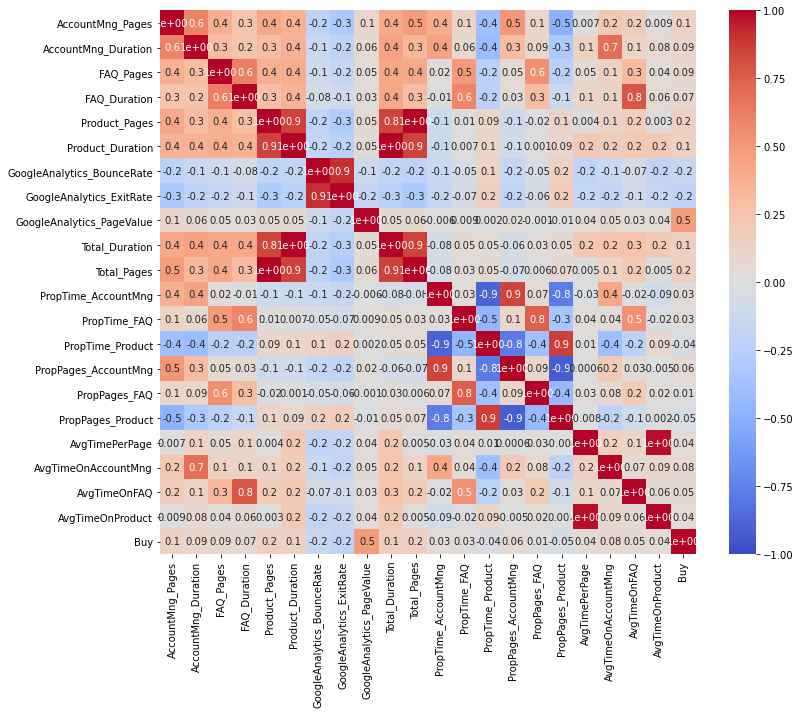

In [10]:
# Prepare figure
fig = plt.figure(figsize=(16, 12))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(all_train_metric.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)


plt.show()

In [11]:
# Better visualization of correlation values (numerical data)

corr.style.applymap(lambda x: 'background-color : green' if x > 0.85 else ('background-color : red' if x < -0.85 else ''))

# Higly correlated variables:
# Product_Pages - Product_Duration
# Product_Pages - Total_Pages
# Product_Duration - Total_Pages
# Product_Duration - Total_Duration
# GoogleAnalytics_BounceRate - GoogleAnalytics_ExitRate
# PropTime_AccountMng - PropTime_Product
# PropPages_AccountMng - PropPages_Product
# AvgTimePerPage - AvgTimeOnProduct

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Total_Duration,Total_Pages,PropTime_AccountMng,PropTime_FAQ,PropTime_Product,PropPages_AccountMng,PropPages_FAQ,PropPages_Product,AvgTimePerPage,AvgTimeOnAccountMng,AvgTimeOnFAQ,AvgTimeOnProduct,Buy
AccountMng_Pages,1.000000,0.607341,0.383062,0.257018,0.427517,0.368104,-0.224157,-0.317452,0.098760,0.414899,0.490820,0.388693,0.128204,-0.394433,0.508738,0.097996,-0.485421,0.006714,0.229135,0.176206,0.009270,0.136236
AccountMng_Duration,0.607341,1.000000,0.306811,0.243573,0.297514,0.368207,-0.145247,-0.206106,0.062712,0.447906,0.336325,0.449509,0.064209,-0.420483,0.310635,0.086479,-0.305620,0.136109,0.692681,0.126401,0.077571,0.094667
FAQ_Pages,0.383062,0.306811,1.000000,0.619568,0.388860,0.392120,-0.116902,-0.164793,0.045593,0.435840,0.426590,0.024758,0.494957,-0.237544,0.054873,0.551266,-0.240486,0.048020,0.137116,0.318876,0.035501,0.092508
FAQ_Duration,0.257018,0.243573,0.619568,1.000000,0.286341,0.361265,-0.075690,-0.107396,0.029707,0.426925,0.309123,-0.012569,0.594162,-0.248898,0.033620,0.300538,-0.134283,0.106834,0.112657,0.785633,0.059328,0.067538
Product_Pages,0.427517,0.297514,0.388860,0.286341,1.000000,0.857659,-0.205078,-0.292165,0.052234,0.849528,0.997151,-0.110100,0.012210,0.093589,-0.116707,-0.016495,0.112938,0.003722,0.115400,0.184940,0.003298,0.153968
Product_Duration,0.368104,0.368207,0.392120,0.361265,0.857659,1.000000,-0.182203,-0.247843,0.047414,0.994190,0.856928,-0.121251,0.007403,0.105127,-0.096707,0.001340,0.088423,0.213832,0.178758,0.215368,0.216706,0.146034
GoogleAnalytics_BounceRate,-0.224157,-0.145247,-0.116902,-0.075690,-0.205078,-0.182203,1.000000,0.913050,-0.119419,-0.188535,-0.215252,-0.137021,-0.051936,0.130419,-0.171820,-0.049518,0.155592,-0.200716,-0.137118,-0.067424,-0.194165,-0.151626
GoogleAnalytics_ExitRate,-0.317452,-0.206106,-0.164793,-0.107396,-0.292165,-0.247843,0.913050,1.000000,-0.174556,-0.257487,-0.306501,-0.161638,-0.068896,0.160916,-0.200175,-0.057619,0.185537,-0.168779,-0.183785,-0.095904,-0.163592,-0.207968
GoogleAnalytics_PageValue,0.098760,0.062712,0.045593,0.029707,0.052234,0.047414,-0.119419,-0.174556,1.000000,0.051878,0.058253,-0.005827,0.008878,0.002316,0.017166,-0.001242,-0.013541,0.038960,0.049795,0.028656,0.041824,0.486579
Total_Duration,0.414899,0.447906,0.435840,0.426925,0.849528,0.994190,-0.188535,-0.257487,0.051878,1.000000,0.853710,-0.075904,0.052273,0.045760,-0.061739,0.028834,0.047653,0.219512,0.234918,0.265584,0.213985,0.149697


Wrapper and Embeded Methods:

In [10]:
# Create a Stratified KFold with 10 splits
skf = StratifiedKFold(n_splits=10)

In [11]:
#----------------------------- Lasso and Decision Tree -----------------------------
#fold = 1
#
#for train_index, val_index in skf.split(data_metric, target):
#        
#        # Data Partition
#        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
#        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
#        
#        # Scaling the data with MinMaxScaler
#        scaler = MinMaxScaler().fit(X_train)
#        
#        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
#        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)
#
#        X_val_metric_scaled = scaler.transform(X_val)
#        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
#        
#        
#        # CODE FOR LASSO
#        reg = LassoCV()
#        lasso = reg.fit(X_train_metric_scaled, y_train)
#        importance = np.abs(lasso.coef_)
#        
#        # CODE FOR DT
#        gini_importance = DecisionTreeClassifier().fit(X = X_train_metric_scaled, y = y_train).feature_importances_
#        entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X = X_train_metric_scaled, y = y_train).feature_importances_
#        
#        
#        if fold == 1:
#            # Create three empty data frames
#            lasso_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#            gini_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#            entropy_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#            
#        importance_values = pd.Series(importance, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
#        gini_values = pd.Series(gini_importance, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
#        entropy_values = pd.Series(entropy_importance, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
#
#        lasso_results = pd.concat((lasso_results, importance_values), axis=1)
#        gini_results = pd.concat((gini_results, gini_values), axis=1)
#        entropy_results = pd.concat((entropy_results, entropy_values), axis=1)
#        
#        fold+=1
#               
#        
## Add new column with average of importance        
#importance_lasso_list = []
#importance_gini_list = []
#importance_entropy_list = []
#
#for index, row in lasso_results.iterrows():
#    count = 0
#    for elem in row:
#        count+=elem
#    average = count / 10
#    importance_lasso_list.append(average)
#
#for index, row in gini_results.iterrows():
#    count = 0
#    for elem in row:
#        count+=elem
#    average = count / 10
#    importance_gini_list.append(average)
#    
#for index, row in entropy_results.iterrows():
#    count = 0
#    for elem in row:
#        count+=elem
#    average = count / 10
#    importance_entropy_list.append(average)
#
#lasso_results['Average of LASSO Importance'] = importance_lasso_list 
#gini_results['Average of Gini Importance'] = importance_gini_list
#entropy_results['Average of Entropy Importance'] = importance_entropy_list
#dt_results = pd.merge(gini_results['Average of Gini Importance'], entropy_results['Average of Entropy Importance'], left_index = True, right_index = True)
#importance_results = pd.merge(dt_results, lasso_results['Average of LASSO Importance'], left_index = True, right_index = True)
#
#lasso_results.style.applymap(lambda x: 'background-color : green' if x > 0.01 else ('background-color : red' if x < -0.85 else ''))
#
#importance_results.sort_values(by=['Average of LASSO Importance','Average of Gini Importance','Average of Entropy Importance'], ascending=False)

In [12]:
#----------------------------- RFE -----------------------------
#fold = 1
#
#for train_index, val_index in skf.split(data_metric, target):
#        
#        # Data Partition
#        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
#        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
#        
#        # Scaling the data with MinMaxScaler
#        scaler = MinMaxScaler().fit(X_train)
#        
#        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
#        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)
#
#        X_val_metric_scaled = scaler.transform(X_val)
#        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
#        
#        
#        # CODE FOR RFE
#        nof_list = np.arange(1,len(data_metric.columns)+1)  # Array from 1 to 21           
#        high_score = 0
#        nof = 0  # Variable to store the optimum number of features
#        
#        for n in nof_list:
#            
#            model = LogisticRegression()
#            rfe = RFE(model, n)
#            
#            X_train_rfe = rfe.fit_transform(X_train_metric_scaled,y_train)
#            X_val_rfe = rfe.transform(X_val_metric_scaled)
#            
#            model.fit(X_train_rfe,y_train)
#
#            score = model.score(X_val_rfe,y_val)
#            
#            if (score > high_score):
#                high_score = score
#                nof = n
#                selected_features = pd.Series(rfe.support_, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
#                
#        if fold == 1:
#            # Create empty data frame
#            rfe_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#        
#        # Concatenate variables chosen at each partition
#        rfe_results = pd.concat((rfe_results, selected_features), axis=1)
#        
#        print('Fold ',fold)
#        fold+=1
#
## Add new column with count of True's        
#count_rfe_list = []
#for index, row in rfe_results.iterrows():
#    count = 0
#    for elem in row:
#        if elem == True:
#            count+=1
#    count_rfe_list.append(count)
#
#rfe_results['Count'] = count_rfe_list
#
#rfe_results.sort_values(by='Count', ascending=False)

In [13]:
# ------------ Backward Regression  ------------
#fold = 1
#
#for train_index, val_index in skf.split(data_metric, target):
#        
#        # Data Partition
#        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
#        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
#        
#        # Scaling the data with MinMaxScaler
#        scaler = MinMaxScaler().fit(X_train)
#        
#        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
#        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)
#
#        X_val_metric_scaled = scaler.transform(X_val)
#        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
#        
#        
#        # CODE FOR BACKWARD REGRESSION
#        sfs_backward = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=5, direction="backward")
#        sfs_backward.fit(X = X_train_metric_scaled, y = y_train)
#
#        selected_features = pd.Series(sfs_backward.support_, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
#        
#        if fold == 1:
#            # Create empty data frame
#            backward_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#            
#        backward_results = pd.concat((backward_results, selected_features), axis=1)
#        
#        print('Fold ',fold)
#        fold+=1
#        
#        
## Add new column with count of True's        
#count_backward_list = []
#for index, row in backward_results.iterrows():
#    count = 0
#    for elem in row:
#        if elem == True:
#            count+=1
#    count_backward_list.append(count)
#
#backward_results['Count'] = count_backward_list 
#backward_results.sort_values(by='Count', ascending=False)

In [14]:
# ------------ Forward Regression  ------------
#fold = 1
#
#for train_index, val_index in skf.split(data_metric, target):
#        
#        # Data Partition
#        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
#        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
#        
#        # Scaling the data with MinMaxScaler
#        scaler = MinMaxScaler().fit(X_train)
#        
#        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
#        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)
#
#        X_val_metric_scaled = scaler.transform(X_val)
#        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
#        
#        
#        # CODE FOR FORWARD REGRESSION
#        sfs_forward = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=5, direction="forward")
#        sfs_forward.fit(X = X_train_metric_scaled, y = y_train)
#
#        selected_features = pd.Series(sfs_forward.support_, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
#        
#        if fold == 1:
#            # Create empty data frame
#            forward_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#            
#        forward_results = pd.concat((forward_results, selected_features), axis=1)
#        
#        print('Fold ',fold)
#        fold+=1
#        
#        
## Add new column with count of True's        
#count_forward_list = []
#for index, row in forward_results.iterrows():
#    count = 0
#    for elem in row:
#        if elem == True:
#            count+=1
#    count_forward_list.append(count)
#
#forward_results['Count'] = count_forward_list 
#
#forward_results.sort_values(by='Count', ascending=False)

In [15]:
# ------------ Select From Model ------------
#fold = 1
#
#for train_index, val_index in skf.split(data_metric, target):
#        
#        # Data Partition
#        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
#        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
#        
#        # Scaling the data with MinMaxScaler
#        scaler = MinMaxScaler().fit(X_train)
#        
#        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
#        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)
#
#        X_val_metric_scaled = scaler.transform(X_val)
#        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
#        
#        
#        # CODE FOR SELECT FROM MODEL
#        threshold = np.sort(importance)[-3] + 0.01
#
#        sfm = SelectFromModel(lasso, threshold=threshold)
#        sfm.fit(X = X_train_metric_scaled, y = y_train)
#
#        selected_features = pd.Series(sfm.get_support(), index = X_train_metric_scaled.columns, name=f'Partition {fold}')
#        
#        if fold == 1:
#            sfm_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#            
#        sfm_results = pd.concat((sfm_results, selected_features), axis=1)
#        
#        print('Fold ',fold)
#        fold+=1
#        
#        
## Add new column with count of True's        
#count_sfm_list = []
#for index, row in sfm_results.iterrows():
#    count = 0
#    for elem in row:
#        if elem == True:
#            count+=1
#    count_sfm_list.append(count)
#
#sfm_results['Count'] = count_sfm_list 
#
#sfm_results.sort_values(by='Count', ascending=False)

In [16]:
## Final table 
#final_results = pd.DataFrame(index = X_train_metric_scaled.columns)
#
#final_results['Count RFE'] = count_rfe_list
#final_results['Count Backward'] = count_backward_list
#final_results['Count Forward'] = count_forward_list
#final_results['Count SFM'] = count_sfm_list
#
#final_results['Average Importance Lasso'] = importance_results['Average of LASSO Importance']
#final_results['Average Importance Gini'] = importance_results['Average of Gini Importance']
#final_results['Average Importance Entropy'] = importance_results['Average of Entropy Importance']
#
#final_results.sort_values(by = ['Average Importance Lasso', 'Average Importance Gini', 'Average Importance Entropy'], ascending = False, inplace = True)
#final_results

Final Result

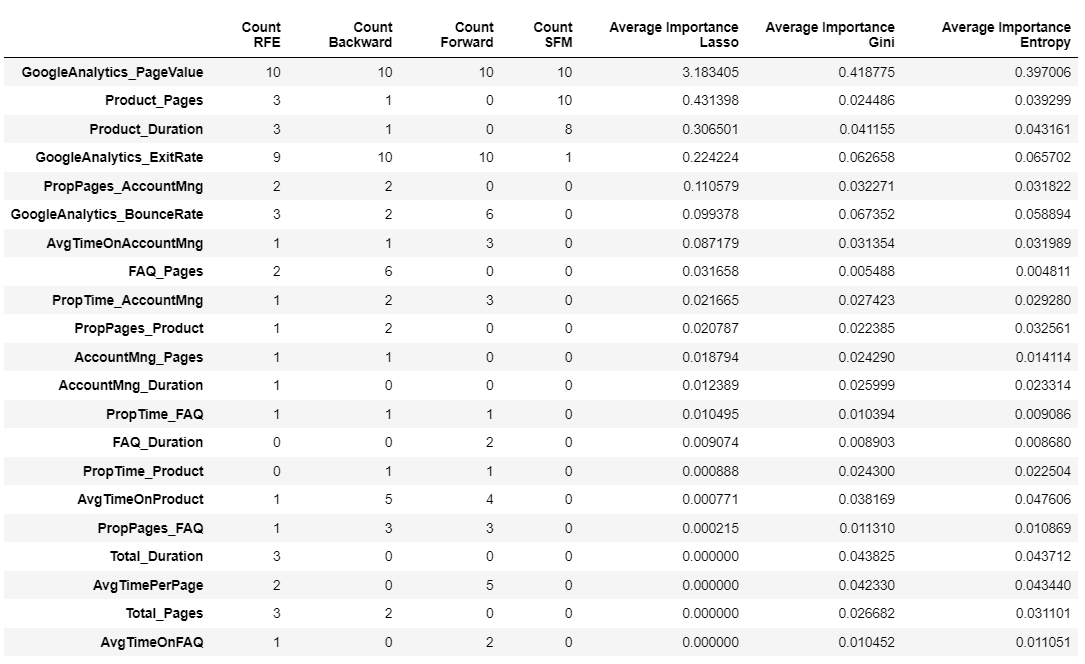

In [25]:
# Chi-Square for categorical data

fold = 1

for train_index, val_index in skf.split(data_non_metric, target):
        
        # Data Partition
        X_train, X_val = data_non_metric.iloc[train_index], data_non_metric.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        # CODE FOR Chi-Square
        if fold == 1:
            chi_square_results = pd.DataFrame(index = X_train.columns)
        
        importance_list = []
        
        for var in data_non_metric:
            
            dfObserved = pd.crosstab(y_train, X_train[var]) 
            chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
            dfExpected = pd.DataFrame(expected, columns = dfObserved.columns, index = dfObserved.index)

            if p < 0.05:
                importance_list.append(True)
            else: 
                importance_list.append(False)
            
        selected_features = pd.Series(importance_list, index = X_train.columns, name=f'Partition {fold}')    
      
        chi_square_results = pd.concat((chi_square_results, selected_features), axis=1)
        
        fold+=1
        
        
# Add new column with count of True's        
count_chi_square_list = []
for index, row in chi_square_results.iterrows():
    count = 0
    for elem in row:
        if elem == True:
            count+=1
    count_chi_square_list.append(count)

chi_square_results['Count'] = count_chi_square_list 

chi_square_results.sort_values(by='Count', ascending=False, inplace = True)

chi_square_results['Keep'] = chi_square_results['Count'].apply(lambda x: 'Yes' if x == 10 else 'No')
chi_square_results[chi_square_results['Keep'] == 'Yes']

,Partition 1,Partition 2,Partition 3,Partition 4,Partition 5,Partition 6,Partition 7,Partition 8,Partition 9,Partition 10,Count,Keep
Apple,True,True,True,True,True,True,True,True,True,True,10,Yes
Mar,True,True,True,True,True,True,True,True,True,True,10,Yes
Traffic_15,True,True,True,True,True,True,True,True,True,True,10,Yes
Windows,True,True,True,True,True,True,True,True,True,True,10,Yes
Traffic_13,True,True,True,True,True,True,True,True,True,True,10,Yes
Traffic_12,True,True,True,True,True,True,True,True,True,True,10,Yes
Traffic_8,True,True,True,True,True,True,True,True,True,True,10,Yes
Oct,True,True,True,True,True,True,True,True,True,True,10,Yes
Nov,True,True,True,True,True,True,True,True,True,True,10,Yes
Traffic_3,True,True,True,True,True,True,True,True,True,True,10,Yes


# Choose the most relevant features

In [17]:
selected_features = ['GoogleAnalytics_PageValue', 
                   'GoogleAnalytics_ExitRate', 
                   'Product_Pages',
                   'AvgTimeOnAccountMng', 
                   'PropPages_AccountMng',
                   'Traffic_13',
                   'Traffic_12',
                   'Traffic_8',
                   'Traffic_3',
                   'Traffic_2',
                   'Traffic_15',
                   'Apple',
                   'Windows',
                   'Returner',
                   'New_Access',
                   'Covid',
                   'Dec',
                   'Feb',
                   'May',
                   'Mar',
                   'Nov',
                   'Oct',
                  ]

data_selected_features = data[selected_features]

## PCA Analysis

In [13]:
# ------------------- Principal Components Analysis ------------

# Perform PCA to reduce dimensionality and retain the best combinations of the most important variables

data_pca = data_metric_scaled.copy() # para confirmar
pca = PCA()
pca_feat = pca.fit_transform(data_pca)
pca_feat
pd.DataFrame({"Eigenvalue": pca.explained_variance_,
            "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
             "Proportion": pca.explained_variance_ratio_,
             "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
            index=range(1, pca.n_components_ + 1))

,Eigenvalue,Difference,Proportion,Cumulative
1,1.244445e-01,0.000000e+00,4.846793e-01,0.484679
2,7.550536e-02,-4.893917e-02,2.940739e-01,0.778753
3,1.736424e-02,-5.814112e-02,6.762922e-02,0.846382
4,1.228480e-02,-5.079433e-03,4.784614e-02,0.894229
5,6.867328e-03,-5.417475e-03,2.674647e-02,0.920975
6,4.793074e-03,-2.074254e-03,1.866779e-02,0.939643
7,3.804722e-03,-9.883524e-04,1.481841e-02,0.954461
8,2.577348e-03,-1.227373e-03,1.003811e-02,0.964499
9,2.474126e-03,-1.032221e-04,9.636084e-03,0.974135
10,2.234188e-03,-2.399379e-04,8.701588e-03,0.982837


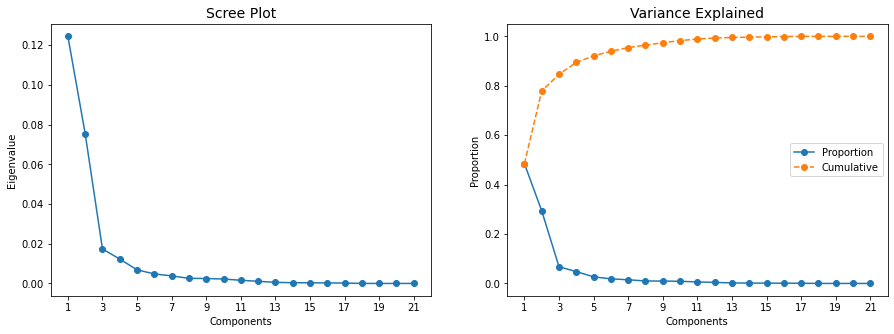

In [14]:
# Scree plot and variance explained plot

# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [15]:
# Perform PCA again with the number of principal components to retain based on the 3 criteria -> 3 PCs
pca = PCA(n_components=3)
pca_feat = pca.fit_transform(data_pca)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=data_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
display(pca_df)

# If we want to select the variables from PCA
data_selected_pca = pca_df.copy()

,PC0,PC1,PC2
0,0.098057,-0.172049,-0.109643
1,0.093331,-0.171873,-0.058509
2,0.149210,-0.145292,-0.075843
3,-0.040201,-0.234154,-0.088367
4,-0.161936,-0.112373,0.018266
...,...,...,...
9994,-0.224861,0.029203,0.003080
9995,-0.724729,1.147112,-0.216691
9996,0.071471,-0.184240,-0.071209
9997,0.065234,-0.185998,-0.025336


<a class="anchor" id="15th-bullet">

## Final Insights:
    
</a>

<hr>

### Numerical Data

| Predictor | Spearman | RFE | Lasso | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- |--- |
| AccountMng_Pages | Discard | Keep | Keep ?| Include in the model |
| AccountMng_Duration | Discard | Keep | Keep | Include in the model |
| FAQ_Pages | Discard | Discard | Keep | Try with and without |
| FAQ_Duration | Discard | Discard | Discard |  Discard |
| Product_Pages | Discard | Discard | Discard |  Discard |
| Product_Duration | Discard | Keep | Keep | Include in the model |
| GoogleAnalytics_BounceRate | Discard | Discard | Keep ? | Discard |
| GoogleAnalytics_ExitRate | Discard | Keep | Keep ?| Include in the model |
| GoogleAnalytics_PageValue | Discard | Keep | Keep | Include in the model |
| Total_Duration | Discard | Discard | Discard |  Discard |
| Total_Pages | Discard | Keep | Keep | Include in the model |
| PropTime_AccountMng | Discard | Discard | Discard |  Discard |
| PropTime_FAQ | Discard | Discard | Discard |  Discard |
| PropTime_Product | Discard | Keep | Keep | Include in the model |
| PropPages_AccountMng | Discard | Discard | Keep ? | Discard |
| PropPages_FAQ | Discard | Keep | Keep ?| Include in the model |
| PropPages_Product | Discard | Keep | Keep | Include in the model |
| AvgTimeOnAccountMng | Discard | Discard | Keep | Try with and without |
| AvgTimeOnFAQ | Discard | Discard | Keep | Try with and without |
| AvgTimeOnProduct | Discard | Discard | Keep | Try with and without |
| Month | Discard | Discard | Discard |  Discard | 


<hr>


### Categorical Data

| Predictor | Chi-Square | 
| --- | --- | 
| OS | Keep |  
| Country | Discard | 
| Type_of_Visitor | Keep |

<hr>

# MODEL EVALUATION

### FUNCTION TO RUN THE ALL THE GRIDS

In [18]:
def run_grid(scaler, model, parameters):

    # ---------- SCALE THE DATA_SELECTED-FEATURES ----------
    #Separate data_selected_features in metric and non metric features
    data_metric = data_selected_features.select_dtypes(include=np.number).set_index(data_selected_features.index)
    data_non_metric = data_selected_features.select_dtypes(exclude=np.number).set_index(data_selected_features.index)

    # -------------- Create a scalling method --------------       
    data_metric_scaled = scaler.fit_transform(data_metric)
    data_metric_scaled = pd.DataFrame(data_metric_scaled, columns = data_metric.columns).set_index(data_metric.index)  

    # Join the metric and non metric variables back together
    data_final = data_metric_scaled.join(data_non_metric)

    
    # ---------- DEFINE OUR GRID SEARCH ----------
    model_grid = GridSearchCV(estimator = model, param_grid = parameters, scoring='f1', n_jobs=-1,cv=3)
    
    grid_search = model_grid.fit(data_final, target)

    print(f'Best parameters= {grid_search.best_params_}')
    print(f'Best score= {grid_search.best_score_}')
    

In [19]:
def run_grid_pca(scaler, model, parameters):

    data_non_metric = data_selected_features.select_dtypes(exclude=np.number).set_index(data_selected_features.index)
    data_final = data_non_metric.join(pca_df) 
    
    # ---------- DEFINE OUR GRID SEARCH ----------
    model_grid = GridSearchCV(estimator = model, param_grid = parameters, scoring='f1', n_jobs=-1,cv=3)
    
    grid_search = model_grid.fit(data_final, target)

    print(f'Best parameters= {grid_search.best_params_}')
    print(f'Best score= {grid_search.best_score_}')
    

### FUNCTION WITH 10 KFLODS TO TEST AVERAGE PERFORMANCE OF THE MODELS

In [20]:
def avg_score(model, split_method, scaler_method, X, y, remove_outliers=True):
    
    score_train = []
    score_val = []
    # Will keep of track of which fold we are in
    fold = 1
    
    for train_index, test_index in split_method.split(X, y=target):
        
        # Data Partition
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        
        # -------------------- REMOVE OUTLIERS --------------------
        if remove_outliers:
            
            # Join X and y training part
            X_y_train = X_train.join(y_train)
            
            iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                              contamination=0.005, max_features=1.0, 
                              bootstrap=False, n_jobs=-1, random_state=1)
    
            # Returns 1 of inliers, -1 for outliers
            pred = iforest.fit_predict(X_train)
            
            # Extract outliers
            inlier_index = np.where(pred==1)
            
            X_y_train_filtered = X_y_train.iloc[inlier_index]   
            
            # Print percentage of outliers removed
            dif = X_y_train.shape[0] - X_y_train_filtered.shape[0]
            perc_outliers = np.round(dif / X_y_train.shape[0] * 100, 2)
            print(f'Percentage of outliers removed from KFold {fold}: {perc_outliers}% ({dif} observations)')
            
            
            # Define data as all the independent variables
            X_train = X_y_train_filtered.drop(['Buy'], axis=1)
            # Define target as the dependent variable
            y_train = X_y_train_filtered['Buy']
                                         
        # ------------------------------------------------------------------------------------------

        # Separate X_train in metric and non metric features
        X_train_metric = X_train.select_dtypes(include=np.number).set_index(X_train.index)
        X_train_non_metric = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

        # Separate X_val in metric and non metric features
        X_val_metric = X_val.select_dtypes(include=np.number).set_index(X_val.index)
        X_val_non_metric = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)


        # Create a scalling method ------------------------------       
        scaler = scaler_method.fit(X_train_metric)

        # Scalling the X_train_metric
        X_train_metric_scaled = scaler.transform(X_train_metric) 
        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train_metric.columns).set_index(X_train_metric.index)  

        # Scalling the X_val_metric
        X_val_metric_scaled = scaler.transform(X_val_metric) 
        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val_metric.columns).set_index(X_val.index)


        # Join the metric and non metric variables back together
        X_train_final = X_train_metric_scaled.join(X_train_non_metric)
        X_val_final = X_val_metric_scaled.join(X_val_non_metric)     


        # Define our model and fit to our scalled data ------------------------------
        model = model.fit(X_train_final, y_train) 


        # Predict the dependent variable
        y_train_pred = model.predict(X_train_final)
        y_val_pred = model.predict(X_val_final)

        # Calculate de f1 score
        value_train = f1_score(y_train, y_train_pred)
        value_val = f1_score(y_val, y_val_pred)        

        # Append results to the lists created above
        score_train.append(value_train)
        score_val.append(value_val)
        fold+=1

                                         
    # Print the results  
    print('\nAverage score of Train:', round(np.mean(score_train), 5))
    print('Average score of Valid:', round(np.mean(score_val), 5))
    print(f'Difference between Train and Validation: {round(np.mean(score_train)-np.mean(score_val), 5)}')

# ----------   MODELS TO TEST   ----------

In [21]:
skf = StratifiedKFold(n_splits=10)

# ---------- MINMAX SCALER ----------
min_max = MinMaxScaler()
min_max2 = MinMaxScaler(feature_range = (-1,1))

# ---------- STANDARD SCALER ----------
standard_scaler = StandardScaler()

# ---------- ROBUST SCALER ----------
robust_scaler = RobustScaler()


# LIST WITH ALL SCALLING METHODS
scalling = [min_max, min_max2, standard_scaler, robust_scaler]

### DECISION TREE

In [26]:
scaler_dt = min_max2
model_dt = DecisionTreeClassifier()
param_dt = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['best', 'random'],
    'max_depth': [4,5,6,7],
    'min_samples_split': [200,300],
    'min_samples_leaf': [200,300],
#    'min_weight_fraction_leaf': [0.0],
    'max_features': [2,4,6, None],
#   'random_state'=None,
    'max_leaf_nodes': [4,8, None],
#    'min_impurity_decrease'=0.0,
#    'min_impurity_split'=None,
#    'class_weight'=None,
#    'ccp_alpha'=0.0,
    }

# ------------------------------------------
run_grid(scaler_dt, model_dt, param_dt)

Best parameters= {'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 200, 'min_samples_split': 200, 'splitter': 'best'}
Best score= 0.6658015379593573


In [62]:
model_dt = DecisionTreeClassifier(    
        criterion='gini',
        max_depth= 3, 
        max_features= 8,
        splitter='best',
        max_leaf_nodes= 8,
        min_samples_leaf= 400,
        min_samples_split= 400,
        )

# -------------------------------------------------------------------------------------------
for scale in scalling:
    print(f'\n----- Score with {scale} -----')
    avg_score(model_dt, skf, scale, data_selected_features, target, remove_outliers=False)
    
#avg_score(model_dt, skf, min_max2, data_selected_features, target, remove_outliers=False)


----- Score with MinMaxScaler() -----

Average score of Train: 0.34067
Average score of Valid: 0.33125
Difference between Train and Validation: 0.00942

----- Score with MinMaxScaler(feature_range=(-1, 1)) -----

Average score of Train: 0.50444
Average score of Valid: 0.5001
Difference between Train and Validation: 0.00434

----- Score with StandardScaler() -----

Average score of Train: 0.47441
Average score of Valid: 0.46247
Difference between Train and Validation: 0.01194

----- Score with RobustScaler() -----

Average score of Train: 0.56509
Average score of Valid: 0.56767
Difference between Train and Validation: -0.00258


### NEURAL NETWORK

In [40]:
scaler_nn = min_max2
model_nn = MLPClassifier()
param_nn = {
    'hidden_layer_sizes': [(8),(6),(4),(6,3),(8,4),(8,4,2)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter' : [100,200],
}


# ------------------------------------------
run_grid(scaler_nn, model_nn, param_nn)

In [41]:
model_nn = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
#    *,
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
#    learning_rate_init=0.001,
#    power_t=0.5,
    max_iter=200,
#    shuffle=True,
#    random_state=None,
#    tol=0.0001,
#    verbose=False,
)

# -------------------------------------------------------------------------------------------
for scale in scalling:
    print(f'\n----- Score with {scale} -----')
    avg_score(model_nn, skf, scale, data_selected_features, target, remove_outliers=False)


----- Score with MinMaxScaler() -----

Average score of Train: 0.5338
Average score of Valid: 0.49723
Difference between Train and Validation: 0.03657

----- Score with MinMaxScaler(feature_range=(-1, 1)) -----

Average score of Train: 0.39114
Average score of Valid: 0.37202
Difference between Train and Validation: 0.01911

----- Score with StandardScaler() -----

Average score of Train: 0.72288
Average score of Valid: 0.65297
Difference between Train and Validation: 0.06991

----- Score with RobustScaler() -----

Average score of Train: 0.62192
Average score of Valid: 0.59074
Difference between Train and Validation: 0.03118


### RANDOM FOREST

### KNN

In [ ]:
# --------------- KNN ---------------
model_KNN = KNeighborsClassifier(
#    n_neighbors=5,
#    *,
    weights='uniform',
#    algorithm='auto',
#    leaf_size=30,
#    p=2,
#    metric='minkowski',
#    metric_params=None,
#    n_jobs=None,
    )


### LOGISTIC

In [ ]:
log_model = LogisticRegression() # Ganda miséria

### INSTANCE BASED LEARNING

### NAIVE BAYES

### SUPPORT VECTOR MACHINES

### RIDGE CLASSIFIER

### ENSEMBLE METHODS

## Bagging

In [22]:
scaler_bag = min_max2
model_bag = BaggingClassifier()

param_bag ={
    'n_estimators':[10,25,100,200],
    'max_samples':[0.8,1,1.2],
    'max_features':[3,5,7,9,11,15,25],
    'bootstrap_features':[True, False],
    'base_estimator':[DecisionTreeClassifier()]
}
# ------------------------------------------

run_grid(scaler_bag, model_bag, param_bag)

Best parameters= {'base_estimator': DecisionTreeClassifier(), 'bootstrap_features': False, 'max_features': 15, 'max_samples': 0.8, 'n_estimators': 100}
Best score= 0.5711370391641291


In [23]:
model_bag = BaggingClassifier(base_estimator= DecisionTreeClassifier(),
                              bootstrap_features= False, 
                              max_features= 15,
                              max_samples= 0.8,
                              n_estimators= 100)


### GRADIENT BOOST


In [39]:
scaler_gb = min_max2
model_gb = GradientBoostingClassifier()

param_gb = {'max_depth': [8,10], 
            'min_samples_split': [500,600],
            'min_samples_leaf' : [5750,625],
            'n_estimators' : [150,200,250],
            'learning_rate' : [0.01,0.2],
            'max_features': ['log2', 'sqrt'],
            'subsample': [0.8] }


# ------------------------------------------
run_grid(scaler_gb, model_gb, param_gb)

Best parameters= {'learning_rate': 0.2, 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 625, 'min_samples_split': 600, 'n_estimators': 200, 'subsample': 0.8}
Best score= 0.6606457710632432


In [38]:
model_gb = GradientBoostingClassifier(
        #    loss='deviance',
            learning_rate=0.2,
            n_estimators=200,
            subsample= 0.8,
        #    criterion='friedman_mse',
            min_samples_split= 500,
            min_samples_leaf= 575,
        #    min_weight_fraction_leaf=0.0,
            max_depth= 8,
        #    min_impurity_decrease=0.0,
        #    min_impurity_split=None,
        #    init=None,
            random_state=50,
            max_features='log2',
        #    verbose=0,
        #    max_leaf_nodes=None,
        #    warm_start=False,
        #    validation_fraction=0.1,
        #    n_iter_no_change=None,
        #    tol=0.0001,
        #   ccp_alpha=0.0,
            )

# -------------------------------------------------------------------------------------------
for scale in scalling:
    print(f'\n----- Score with {scale} -----')
    avg_score(model_gb, skf, scale, data_selected_features, target, remove_outliers=False)
    
#avg_score(model_gb, skf, standard_scaler, data_selected_features, target, remove_outliers=False)


----- Score with MinMaxScaler() -----

Average score of Train: 0.70618
Average score of Valid: 0.65199
Difference between Train and Validation: 0.05419

----- Score with MinMaxScaler(feature_range=(-1, 1)) -----

Average score of Train: 0.70638
Average score of Valid: 0.65198
Difference between Train and Validation: 0.05439

----- Score with StandardScaler() -----

Average score of Train: 0.70523
Average score of Valid: 0.65737
Difference between Train and Validation: 0.04786

----- Score with RobustScaler() -----

Average score of Train: 0.70523
Average score of Valid: 0.65737
Difference between Train and Validation: 0.04786


# Choose the best model and the best scalling method

In [61]:
best_model = model_gb
best_scalling = standard_scaler

In [62]:
# Apply best_model and best_scalling to the dataset with the selected features
remove_outliers = False
random_state = 50  # O que é que isto faz ??? Define que fracao vai para train e para validation

X_train, X_val, y_train, y_val = train_test_split(data_selected_features, target, train_size=0.7, stratify = target, random_state=random_state)


# -------------------- REMOVE OUTLIERS --------------------
if remove_outliers:

    # Join X and y training part
    X_y_train = X_train.join(y_train)

    iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                      contamination=0.005, max_features=1.0, 
                      bootstrap=False, n_jobs=-1, random_state=1)

    # Returns 1 of inliers, -1 for outliers
    pred = iforest.fit_predict(X_train)

    # Extract outliers
    inlier_index = np.where(pred==1)

    X_y_train_filtered = X_y_train.iloc[inlier_index]   

    # Print percentage of outliers removed
    dif = X_y_train.shape[0] - X_y_train_filtered.shape[0]
    perc_outliers = np.round(dif / X_y_train.shape[0] * 100, 2)
    print(f'Percentage of outliers removed from KFold {fold}: {perc_outliers}% ({dif} observations)')


    # Define data as all the independent variables
    X_train = X_y_train_filtered.drop(['Buy'], axis=1)
    # Define target as the dependent variable
    y_train = X_y_train_filtered['Buy']

# ------------------------------------------------------------------------------------------

# Separate X_train in metric and non metric features
X_train_metric = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_non_metric = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)


# Separate X_val in metric and non metric features
X_val_metric = X_val.select_dtypes(include=np.number).set_index(X_val.index)
X_val_non_metric = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)


# Create a scalling method        
best_scaler = best_scalling.fit(X_train_metric)

# Scalling the X_train_metric
X_train_metric_scaled = best_scaler.transform(X_train_metric) 
X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train_metric.columns).set_index(X_train_metric.index)

# Scalling the X_val_metric
X_val_metric_scaled = best_scaler.transform(X_val_metric) 
X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val_metric.columns).set_index(X_val.index)


# Join the X_train and X_val back together
X_train_final = X_train_metric_scaled.join(X_train_non_metric)
X_val_final = X_val_metric_scaled.join(X_val_non_metric)     


# Define our model and fit to our scalled data
best_model_fitted = best_model.fit(X_train_final, y_train)


# Predict the dependent variable
y_train_pred = best_model.predict(X_train_final)
y_val_pred = best_model.predict(X_val_final)

# Calculate de f1 score
value_train = f1_score(y_train, y_train_pred)
value_val = f1_score(y_val, y_val_pred) 


print('------------ FINAL MODEL ------------')
print('Average score of Train:', round(np.mean(value_train), 5))
print('Average score of Valid:', round(np.mean(value_val), 5))
print(f'Difference between Train and Validation: {round(np.mean(value_train)-np.mean(value_val), 5)}')

------------ FINAL MODEL ------------
Average score of Train: 0.71591
Average score of Valid: 0.64989
Difference between Train and Validation: 0.06603


# Performance Measures

In [63]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [64]:
#def metrics(y_train, pred_train , y_val, pred_val):
#    print('___________________________________________________________________________________________________________')
#    print('                                                     TRAIN                                                 ')
#    print('-----------------------------------------------------------------------------------------------------------')
#    print(classification_report(y_train, pred_train))
#    print(confusion_matrix(y_train, pred_train))
#
#
#    print('___________________________________________________________________________________________________________')
#    print('                                                VALIDATION                                                 ')
#    print('-----------------------------------------------------------------------------------------------------------')
#    print(classification_report(y_val, pred_val))
#    print(confusion_matrix(y_val, pred_val))

In [65]:
#labels_train = log_model.predict(X_train)
#labels_val = log_model.predict(X_val)

In [66]:
#metrics(y_train=y_train, pred_train=labels_train , y_val=y_val, pred_val=labels_val)

# Deployment

In [5]:
test = pd.read_csv('test.csv')
test.head(3)

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor
0,798519314,24-Aug-20,0,0.0,0,0.0,86,5332.5478,0.0139,0.0654,0.0,Windows,2,Brazil,1,Returner
1,798663101,25-May-20,2,37.5,0,0.0,55,1420.4725,0.0012,0.0058,0.0,Android,1,Spain,4,Returner
2,798663221,2-Nov-20,0,0.0,0,0.0,36,788.5000,0.0000,0.0250,0.0,Windows,6,Spain,3,Returner


### Change type of variables

In [6]:
test = change_data_types(test)
test.dtypes

Access_ID                             string
Date                          datetime64[ns]
AccountMng_Pages                       int64
AccountMng_Duration                  float64
FAQ_Pages                              int64
FAQ_Duration                         float64
Product_Pages                          int64
Product_Duration                     float64
GoogleAnalytics_BounceRate           float64
GoogleAnalytics_ExitRate             float64
GoogleAnalytics_PageValue            float64
OS                                    string
Browser                               string
Country                               string
Type_of_Traffic                       string
Type_of_Visitor                       string
dtype: object

## Check inchoerencies in the dataset

In [69]:
#test = inchorencies_check(test)
#test.shape

### Create new variables

In [7]:
test = create_new_variables(test)
print(test.shape)

NameError: name 'create_new_variables' is not defined

In [71]:
# best_model_fitted
# best_scaler

# Apply best_model_fitted and best_scaler to the dataset
test_data = test[selected_features]

# Separate test_data in metric and non metric features
test_data_metric = test_data.select_dtypes(include=np.number).set_index(test_data.index)
test_data_non_metric = test_data.select_dtypes(exclude=np.number).set_index(test_data.index)

# Use best_scaler created above
test_data_metric_scaled = best_scaler.transform(test_data_metric) 
test_data_metric_scaled = pd.DataFrame(test_data_metric_scaled, columns = test_data_metric.columns).set_index(test_data.index)

# Join the test_data back together
test_data_final = test_data_metric_scaled.join(test_data_non_metric)


# Use best_model_fitted created above to create new columns called 'Buy'
test_data_final['Buy'] = best_model_fitted.predict(test_data_final)

display(test_data_final.head(3))

,GoogleAnalytics_PageValue,GoogleAnalytics_ExitRate,Product_Pages,AvgTimeOnAccountMng,PropPages_AccountMng,Traffic_13,Traffic_12,Traffic_8,Traffic_3,Traffic_2,...,Returner,New_Access,Covid,Dec,Feb,May,Mar,Nov,Oct,Buy
0,-0.316034,0.443342,1.255868,-0.472651,-0.627845,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,0
1,-0.316034,-0.769782,0.541947,-0.022674,-0.356880,False,False,False,False,False,...,True,False,True,False,False,True,False,False,False,0
2,-0.316034,-0.378977,0.104382,-0.472651,-0.627845,False,False,False,True,False,...,True,False,True,False,False,False,False,True,False,0


In [72]:
test_data_final['Buy'].value_counts()

0    2002
1     298
Name: Buy, dtype: int64

In [73]:
test_data_final['Access_ID'] = test['Access_ID']

sample_submission = test_data_final[['Access_ID', 'Buy']]
sample_submission

,Access_ID,Buy
0,798519314,0
1,798663101,0
2,798663221,0
3,798760918,0
4,798856982,0
...,...,...
2295,962042726,0
2296,962063064,0
2297,962147749,1
2298,962182167,0


In [76]:
# Change name of file - TIAGO
sample_submission.to_csv(r'C:\Users\tsoom\OneDrive\Documentos\IMS - Data Science\Machine Learning\Github Project\Project-Machine-Learning\submissions\sub71.csv', index=False, sep=',')

text_file = open("submissions/sub71.txt", "w")
n = text_file.write((str(best_model)+'\n\n'+str(selected_features)+'\n\n'+ str(best_scalling)+'\n\n'+ str(random_state)))
text_file.close()  # exportar também o modelo utilizado, alterar numero aqui e no csv para a correspondencia estar certa

In [75]:
# Change name of file  - JOHNNY
sample_submission.to_csv(r'C:\Users\Admin\Documents\GitHub\Project-Machine-Learning\submissions\35.csv', index=False, sep=',')

text_file = open("submissions/sub35.txt", "w")
n = text_file.write((str(best_model)+'\n\n'+str(selected_variables)+'\n\n'+ str(best_scalling)+'\n\n'+ str(random_state)+'\n\nValue'+ str(round(np.mean(value_train), 5))+'\n\n'+ str(round(np.mean(value_val), 5))))
text_file.close()  # exportar também o modelo utilizado, alterar numero aqui e no csv para a correspondencia estar certa

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Admin\\Documents\\GitHub\\Project-Machine-Learning\\submissions\\35.csv'